In [14]:
import sys
import glob
import multiprocessing as mp

sys.path.append("../")

from tools.rosetta import run_rosetta, rosetta_parser

ROSETTA_PATH = "/opt/apps/rosetta-3.12/main/source/bin"

# Perform some simple calculations with rosetta

In [5]:
run = run_rosetta.RunRosetta(ROSETTA_PATH)  # initialize the class
samples = glob.glob("files/*.pdb")

for sample in samples:
    run.run_fast_relax(
        sample,
        extra_flags="-out:no_nstruct_label -out:suffix _relaxed -out:level 100",  # remove _000x labels, adds suffix and surpress redundant info from Rosetta
        out_dir="rosetta_output",
    )  # run fast relax
for output in glob.glob("rosetta_output/*.pdb"):
    run.run_interface_analysis(
        output,
        interchain_interface=["A", "B"],  # chain A and B.
        extra_flags="-out:no_nstruct_label -out:suffix _interface -out:level 100",
        out_file="rosetta_output/interface_analysis.sc",
    )  # run interface analysis
    run.run_residue_energy_breakdown(
        output,
        extra_flags="-out:no_nstruct_label -out:suffix _decomposition -out:level 100",
        out_file="rosetta_output/decomposition.dat",
    )  # run residue energy breakdown

# Use scripts for data analysis

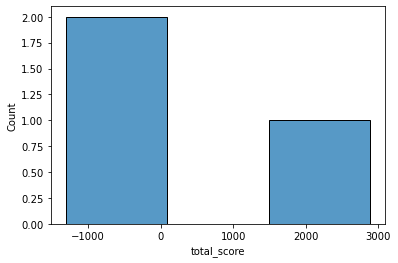

,SCORE:,total_score,dslf_fa13,fa_atr,fa_dun,fa_elec,fa_intra_rep,fa_intra_sol_xover4,fa_rep,fa_sol,...,hbond_sc,hbond_sr_bb,lk_ball_wtd,omega,p_aa_pp,pro_close,rama_prepro,ref,yhh_planarity,description
0,SCORE:,-1310.547,-7.004,-2873.249,499.978,-853.204,6.026,82.736,284.250,1755.548,...,-53.691,-331.824,-80.965,65.676,-77.524,1.759,-6.693,346.555,0.225,refchanged
1,SCORE:,2885.864,-7.111,-2539.494,641.350,-706.912,5.185,78.269,3784.007,1654.747,...,-32.407,-322.804,-66.794,87.556,-48.833,4.283,52.663,349.191,0.167,file1changed
2,SCORE:,-920.188,-6.470,-2624.498,556.598,-730.089,5.285,76.585,231.281,1705.669,...,-25.784,-334.583,-79.190,65.145,-64.128,4.635,-2.335,348.517,0.454,file2changed


In [12]:
rp = rosetta_parser.RosettaParser("rosetta_output/score_minim.sc")
rp.change_strings_in_selected_column_by_user_input("description", "_relaxed", "changed")
rp.plot_histogram("total_score")
rp.read_dataframe()

# Multithreading usage with run scripts

In [15]:
def worker(sample):
    instance = run_rosetta.RunRosetta(ROSETTA_PATH)
    instance.run_fast_relax(
        sample,
        extra_flags="-out:no_nstruct_label -out:suffix _relaxed_mpi -out:level 100",  # remove _000x labels, adds suffix and surpress redundant info from Rosetta
        out_dir="rosetta_output")

num_cpu = 3
pool = mp.Pool(processes=num_cpu)        
pool.map(worker, samples)
pool.close()
pool.join()
